# Classificador d'alumnes del curs


In [1]:
# Reconeixement de cares d'alumnes del curs de visio

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms


import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

## carregar el dataset de train i de test

In [2]:
# seleccionar GPU si està disponible..
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print(device)

dataset_dir = 'data/'
train_dir = os.path.join(dataset_dir,'train')
test_dir = os.path.join(dataset_dir,'test')

# transformacio standard ImageNet
transform = transforms.Compose([
                transforms.Resize(224),   #mida d'entrada de la xarxa neuronal
                transforms.CenterCrop(224),    #important. Sinó dóna error perquè les imatges no son quadrades       
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])  #mitja i desviacio estandard


batch_size=20
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Loading datasets into dataloader 
dataloaders = {'train': torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = True),
               'test': torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle = True)}

dataset_sizes = {'train': len(train_dataset),
                 'test': len(test_dataset)}

print("Total Number of Samples: ",len(train_dataset) + len(test_dataset))
print("Number of Samples in Train: ",len(train_dataset))
print("Number of Samples in Test: ",len(test_dataset))
print("Number of Classes: ",len(train_dataset.classes))

class_names = train_dataset.classes
print(class_names)
print("\n\n")



## Mostrar imatges del dataset
def imshow(inp, title=None):
    plt.figure(figsize = (15,5))
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        #plt.title(title)
        print(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
images, classes = next(iter(dataloaders['train'])) 

# Make a grid from batch
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in classes])


Total Number of Samples:  323
Number of Samples in Train:  255
Number of Samples in Test:  68
Number of Classes:  10
['DanielValcarce', 'EnriqueGraziano', 'Francisco', 'Genis', 'JordiCasals', 'MarcelSerra', 'OriolJulia', 'Pere', 'RicardPeralta', 'RogerRoca']





## Generar el model. Epoch:  train + test  loop

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                        
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracy.append(epoch_acc)
            else:
                test_losses.append(epoch_loss)
                test_accuracy.append(epoch_acc)
            
            # deep copy dels pesos del model. Si l'accuracy es millor en aquest epoch.
            if phase == 'test' and epoch_acc > best_acc:                
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

     
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    #per guardar el model
    PATH = 'model_UOC.pth'
    torch.save(model, PATH)
    
   
    return model

In [4]:
def visualize_model(model, num_images=20):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            
            sm = torch.nn.Softmax(dim=1) # Get probabilities from outputs
            probs = sm(outputs)
            
            _, preds = torch.max(outputs, 1)
            #print(preds)
            #print(labels)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.subplot(num_images//2, 3, images_so_far)
                #imshow(inputs.cpu().data[j])                
                plt.imshow(inputs.cpu().data[j][0],  cmap='gray')                
                
                # Get the probability for the predicted image
                img_prob = probs[j].cpu().detach().numpy()[preds[j]] * 100
                plt.title('nom predit: {} ({:.2f}%)\n nom real:{}'.format((class_names[preds[j]]), img_prob, class_names[labels[j]]))
            
                
                # Mostrem la figura més gran per veure les imatges
                fig = plt.gcf()
                fig.set_size_inches(12,60)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Selecció del model. Transfer Learning  a un model preentrenat.

In [5]:
# Confgiure Hyperparamters
batch_size = 4
epochs = 15
opt_lr = 0.05
opt_momentum = 0.9
sch_gamma = 0.15
sch_step = 3



# Transfer Learning: agafem un model ja entrenat
# Utilitzarem el mètode Fixed Feature Extractor: fixar totes les capes menys la última
# d'aquesta manera entrenem només la capa final.

# Model elegit resnet18
model_ft = models.resnet18(pretrained=True)

# Congelem tots els pesos del model per a no perdre l'entrenament ja fet
for param in model_ft.parameters():
    param.requires_grad = False

#print(model_ft)

# substituim la darrera capa per una capa fully connected que passi de num_filters a nombre classes
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

#print(model_ft)

# les noves capes afegides tenen els pesos 'actius' per defecte. Aquests pesos seran els únics a entrenar
total_params = sum(p.numel() for p in model_ft.parameters())
print('total parameters {}'.format(total_params))
total_trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print('total trainable parameters {}'.format(total_trainable_params))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_ft.fc.parameters(), lr=opt_lr, momentum=opt_momentum)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=sch_step, gamma=sch_gamma)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 25.1MB/s]


total parameters 11181642
total trainable parameters 5130


## Entrenament i visualització gràfica epochs

In [6]:
# Entrenar el model

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

# 15 epochs. No millora amb més. 
model_conv = train_model(model_ft, criterion, optimizer_conv, exp_lr_scheduler, epochs)

Epoch 0/14
----------
train Loss: 4.5237 Acc: 0.2392
test Loss: 4.5134 Acc: 0.1471
Epoch 1/14
----------
train Loss: 2.1614 Acc: 0.6118
test Loss: 2.4031 Acc: 0.6618
Epoch 2/14
----------
train Loss: 1.7056 Acc: 0.7294
test Loss: 0.8682 Acc: 0.8382
Epoch 3/14
----------
train Loss: 0.4463 Acc: 0.9098
test Loss: 0.5028 Acc: 0.8824
Epoch 4/14
----------
train Loss: 0.2105 Acc: 0.9569
test Loss: 0.4660 Acc: 0.8676
Epoch 5/14
----------
train Loss: 0.1771 Acc: 0.9529
test Loss: 0.2719 Acc: 0.9118
Epoch 6/14
----------
train Loss: 0.0617 Acc: 0.9765
test Loss: 0.2896 Acc: 0.9118
Epoch 7/14
----------
train Loss: 0.0837 Acc: 0.9725
test Loss: 0.2705 Acc: 0.8971
Epoch 8/14
----------
train Loss: 0.1178 Acc: 0.9608
test Loss: 0.2474 Acc: 0.9265
Epoch 9/14
----------
train Loss: 0.0793 Acc: 0.9725
test Loss: 0.2613 Acc: 0.9118
Epoch 10/14
----------
train Loss: 0.0725 Acc: 0.9647
test Loss: 0.2544 Acc: 0.9118
Epoch 11/14
----------
train Loss: 0.0829 Acc: 0.9686
test Loss: 0.2549 Acc: 0.9118
Ep

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.6/site

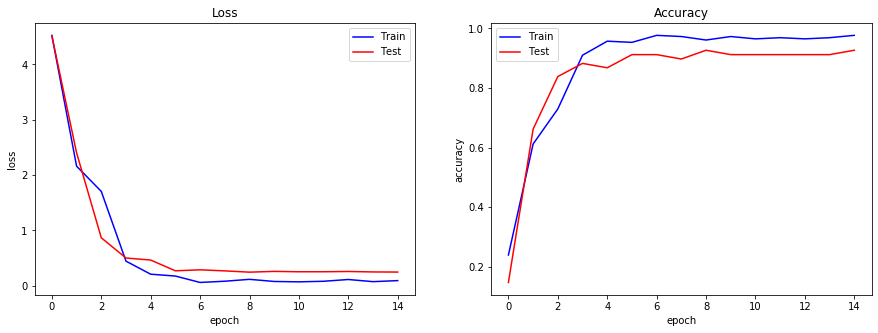

In [7]:
# Visualitzar resultats per a cada epoch

fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(train_losses, color='blue', label='Train')
plt.plot(test_losses, color='red', label='Test')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracy, color='blue', label='Train')
plt.plot(test_accuracy, color='red', label='Test')
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.legend()

## Validació del model. Visualitzar resultats

In [ ]:
#resultats
visualize_model(model_conv)


# Carregar el model guardat en un arxiu

In [51]:
import torchvision
from PIL import Image
import torch
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PATH = 'model_UOC.pth'
img_path = "im_proves/marcel.jpg"
llista_labels= ['DanielValcarce', 'EnriqueGraziano', 'FranciscoMartin', 'GenisHeredia', 'JordiCasals', 'MarcelSerra', 'OriolJulia', 'PereClaver', 'RicardPeralta', 'RogerRoca']

model_load = torch.load(PATH)
model_load.eval()


img = Image.open(img_path)
# Defing PyTorch Transform
transform = transforms.Compose([
                transforms.Resize(224),   #mida d'entrada de la xarxa neuronal
                transforms.CenterCrop(224),    #important. Sinó dóna error perquè les imatges no son quadrades       
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])  #mitja i desviacio estandard

# Apply the transform to the image
img = transform(img) 
img = img.to(device)

# Pass the image to the model
pred = model_load(img[None, ...])
_, preds = torch.max(pred, 1)

print(pred)
print(preds[0])

resultat= llista_labels[preds]
print(resultat)






# evaluar
#visualize_model(model_load)

tensor([[-3.4259, -0.6724, -4.7281, -2.6082,  1.7974, 15.4678,  0.8477, -6.2000,
          0.0173, -3.9049]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor(5, device='cuda:0')
MarcelSerra
